In [1]:
import eli5
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OrdinalEncoder
from eli5.sklearn import PermutationImportance
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels
from xgboost import XGBRFClassifier, XGBClassifier
from jupyterthemes import jtplot

In [2]:
%matplotlib inline
jtplot.style(grid=False)
pd.set_option('display.max_columns', 500)

In [3]:
# test = pd.read_stata("C:\\Users\Paul\PycharmProjects\BlogPost\data\WA_BRFSS_11to17_B.dta",
#                      convert_missing=False)

In [7]:
%run -i main.py

In [8]:
df.head()

,Age,Race,Income,Over Median Income,Ownership,Total Household,Zip Code,In Food Desert,Employment,Active,Overweight,Diabetic,Good Health,No Fruit,No Veg,Fruit Daily,Veg Daily,Fruit Weekly,Veg Weekly,Fruit Monthly,Veg Monthly,Sleep Hrs,Insurance,Dr Too Much,Recent Dr Visit,Smoker,Alcohol
7021,55-59,White,$50-75K,False,Own,4.0,98648,False,Employed for wages,Does not meet Aerobic Recs,Over,False,Very Good,False,False,False,False,False,True,False,False,NaN,Yes,No,2-5 years,Never Smoked,05
9722,40-44,NaN,$20-25K,False,Own,2.0,98607,False,Employed for wages,Does not meet Aerobic Recs,Normal,False,Poor,False,False,False,False,True,False,False,False,NaN,Yes,Yes,Past Year,Current - Every Day,02
2557,60-64,White,$75+,True,Own,3.0,98407,False,Employed for wages,Meets Aerobic Recs,Obese,False,Good,False,False,False,False,False,False,False,False,NaN,Yes,No,Past Year,Never Smoked,04
5489,75-79,White,$15-20K,False,Own,1.0,98133,False,Retired,Meets Aerobic Recs,Obese,True,Fair,False,False,False,False,False,False,False,True,NaN,Unknown,No,Past Year,Former Smoker,Unknown
12037,70-74,White,Refused,False,Own,2.0,98365,False,Retired,Meets Aerobic Recs,Unknown,False,Very Good,False,False,False,False,True,True,False,False,NaN,Unknown,No,Past Year,Former Smoker,28


In [9]:
df['Alcohol'].value_counts()

Unknown    15327
01          3051
02          2310
30          2088
20          1746
4           1569
8           1463
03          1419
12          1416
05          1234
04          1198
28          1062
10           982
15           911
16           638
25           553
06           459
08           374
07           321
24           284
0             73
14            57
29            46
18            29
27            28
09            24
26            23
21            21
17            18
22            16
13            12
23             8
11             7
19             4
Name: Alcohol, dtype: int64

In [11]:
# df['Pre Diabetic'] = df['Pre Diabetic'].astype(int)
# df.describe()

In [12]:
def train_val_test_split(X, y):
    trainval, test, y_trainval, y_test = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          random_state=42,
                                                          )
    train, val, y_train, y_val = train_test_split(trainval,
                                                 y_trainval,
                                                 stratify=y_trainval,
                                                 random_state=42)
    return train, val, test, y_train, y_val, y_test

In [13]:
target = 'Diabetic'
y = df[target].astype(bool)
X = df.drop(columns=target)

In [14]:
train, val, test, y_train, y_val, y_test = train_val_test_split(X, y)
train.shape, val.shape, test.shape, y_train.shape, y_val.shape, y_test.shape

((21834, 26), (7279, 26), (9705, 26), (21834,), (7279,), (9705,))

In [15]:
# Predict majority class as baseline.
y.value_counts(normalize=True)

False    0.889149
True     0.110851
Name: Diabetic, dtype: float64

In [16]:

roc_auc_score(y_train, np.full(y_train.shape, 0))

0.5

In [17]:
pipeline = make_pipeline(OrdinalEncoder(),
                         SimpleImputer())

In [18]:
X_train = pipeline.fit_transform(train)
X_val = pipeline.transform(val)
X_test = pipeline.transform(test)
X_train.shape, X_val.shape, X_test.shape

((21834, 26), (7279, 26), (9705, 26))

In [19]:
eval_set = [(X_train, y_train),
            (X_val, y_val)]

In [20]:
model = XGBRFClassifier(n_jobs=-1,
                        n_estimators=5000,
                        early_stopping_rounds=100,
                        random_state=42,
                        scale_pos_weight=15,
                        learning_rate=.005,
                        reg_lambda=.01,
                        verbosity=1)

In [21]:
model.fit(X_train,
          y_train,
          eval_set=eval_set,
          eval_metric='auc',
          verbose=True)

[0]	validation_0-auc:0.799485	validation_1-auc:0.801136


XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, early_stopping_rounds=100, gamma=0,
                learning_rate=0.005, max_delta_step=0, max_depth=3,
                min_child_weight=1, missing=None, n_estimators=5000, n_jobs=-1,
                nthread=None, objective='binary:logistic', random_state=42,
                reg_alpha=0, reg_lambda=0.01, scale_pos_weight=15, seed=None,
                silent=None, subsample=0.8, verbosity=1)

Validation ROC AUC score: 0.8011360155193356


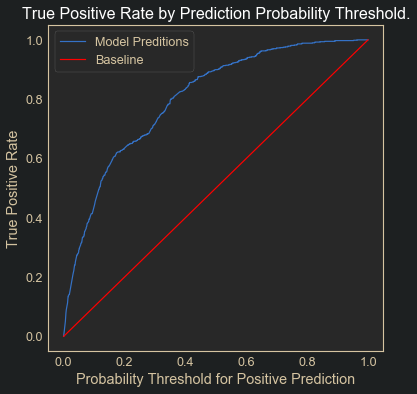

In [22]:
y_pred_proba = model.predict_proba(X_val)[:, 1]
print(f'Validation ROC AUC score: {roc_auc_score(y_val, y_pred_proba)}')
curves = roc_curve(y_val, y_pred_proba)
curve_x, curve_y = curves[0], curves[1]
x_ = np.linspace(0, 1, len(curve_x))
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()
y_ = x_
plt.plot(curve_x, curve_y, label='Model Preditions')
plt.plot(x_, y_, color='red', label='Baseline')
plt.title('True Positive Rate by Prediction Probability Threshold.',
          fontsize=16,
          color='white')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('Probability Threshold for Positive Prediction')
plt.legend();

In [23]:
permuter = PermutationImportance(model,
                                 cv='prefit',
                                 n_iter=5,
                                 scoring='roc_auc',
                                 random_state=42)
permuter.fit(X_val, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBRFClassifier(base_score=0.5,
                                                colsample_bylevel=1,
                                                colsample_bynode=0.8,
                                                colsample_bytree=1,
                                                early_stopping_rounds=100,
                                                gamma=0, learning_rate=0.005,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=1,
                                                missing=None, n_estimators=5000,
                                                n_jobs=-1, nthread=None,
                                                objective='binary:logistic',
                                                random_state=42, reg_alpha=0,
                                                reg_lambda=0.01,
                    

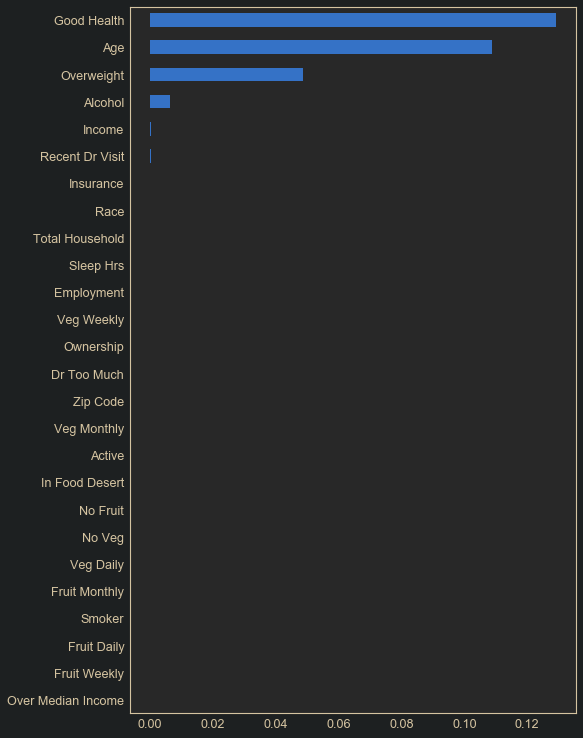

In [24]:
features_of_import = pd.Series(permuter.feature_importances_, val.columns)
plt.figure(figsize=(8, len(val.columns) / 2))
features_of_import.sort_values(ascending=True).plot.barh();

In [25]:
mask = features_of_import > 0
trimmed_columns = train.columns[mask]
train_trimmed = train[trimmed_columns]
val_trimmed = val[trimmed_columns]
test_trimmed = test[trimmed_columns]

pipeline1 = make_pipeline(OrdinalEncoder(),
                          SimpleImputer())

X_train_ = pipeline1.fit_transform(train_trimmed)
X_val_ = pipeline1.transform(val_trimmed)
X_test_ = pipeline1.transform(test_trimmed)

eval_set1 = [(X_train_, y_train),
            (X_val_, y_val)]

In [26]:
model.fit(X_train_, y_train, eval_set=eval_set1, eval_metric='auc')
y_pred_proba = model.predict_proba(X_val_)[:, 1]
print(f'XGBRFClassifier validation ROC AUC: {roc_auc_score(y_val, y_pred_proba)}')

[0]	validation_0-auc:0.800127	validation_1-auc:0.801818
XGBRFClassifier validation ROC AUC: 0.8018182030533205


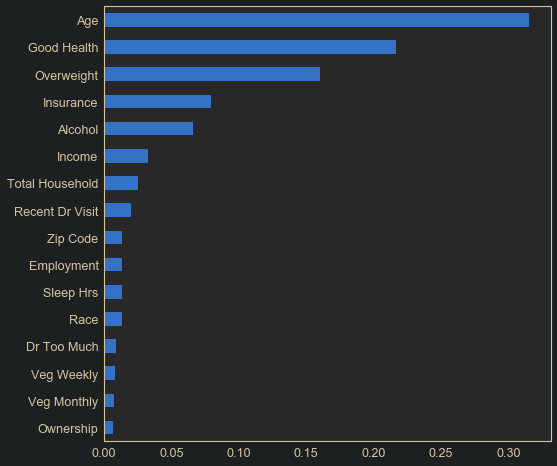

In [27]:
importance = pd.Series(model.feature_importances_, val_trimmed.columns)
plt.figure(figsize=(8, len(val_trimmed.columns) / 2))
importance.sort_values(ascending=True).plot.barh()


In [28]:
params = {'n_estimators': [100, 500, 1000, 5000, 10000],
          'scale_pos_weights': [1, 5, 10, 15, 20],
          'learning_rate': [.0001, .001, .01, .02, .05],
          'reg_lambda': [.0001, .001, .01, .02, .05]}
search = RandomizedSearchCV(model,
                            param_distributions=params,
                            scoring='roc_auc',
                            n_iter=50,
                            cv=5,
                            n_jobs=-1)
search.fit(X_train_, y_train)
search.best_estimator_, search.best_params_, search.best_score_

(XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                 colsample_bytree=1, early_stopping_rounds=100, gamma=0,
                 learning_rate=0.05, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=5000, n_jobs=-1,
                 nthread=None, objective='binary:logistic', random_state=42,
                 reg_alpha=0, reg_lambda=0.01, scale_pos_weight=15,
                 scale_pos_weights=15, seed=None, silent=None, subsample=0.8,
                 verbosity=1),
 {'scale_pos_weights': 15,
  'reg_lambda': 0.01,
  'n_estimators': 5000,
  'learning_rate': 0.05},
 0.7977925019934209)

In [29]:
best = search.best_estimator_
y_pred_proba1 = best.predict_proba(X_val_)[:, 1]

In [30]:
def nice_confusion(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                         columns=columns,
                         index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='copper_r')

In [44]:
def set_threshold(y_true, y_pred_proba, threshold=.51):
    
    print(f'Threshold: {threshold}')
    
    # Apply threshold to probabilies of positive prediction.
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1

    # Plot distribution of predicted probabilities.
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='r')
    plt.title('Distribution of predicted probabilities')
    plt.show()
    
    # Calculate true positive and false positive rates.
    true_pos = (y_pred == y_true) & (y_pred == class_1)
    false_pos = (y_pred != y_true) & (y_pred == class_1)
    actual_pos = y_true == class_1
    actual_neg = y_true == class_0
    true_pos_rate = true_pos.sum() / actual_pos.sum()
    false_pos_rate = false_pos.sum() / actual_neg.sum()
    print(f'True Positive Rate: {true_pos_rate:.4f}')
    print(f'False Positive Rate: {false_pos_rate:.4f}')
    
    # Plot ROC curve.
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # Plot point for current threshold.
    plt.scatter(false_pos_rate, true_pos_rate)
    plt.show()
    
    print(f'Area under ROC: {roc_auc_score(y_true, y_pred_proba):.4f}')
    
    nice_confusion(y_true, y_pred)
    print(classification_report(y_true, y_pred))


In [45]:
interact(set_threshold,
        y_true=fixed(y_val),
        y_pred_proba=fixed(y_pred_proba1),
        threshold=(0.49, 0.52, 0.0001));

interactive(children=(FloatSlider(value=0.51, description='threshold', max=0.52, min=0.49, step=0.0001), Outpu…

Hyperparameter tuning.

Test time!!

In [46]:

test_pred_proba = best.predict_proba(X_test_)[:, 1] > 0.5104
print(f'Test ROC AUC: {roc_auc_score(y_test, test_pred_proba)}')

Test ROC AUC: 0.7011977851121036


Find individual instances to examine.

In [47]:
test_trimmed1 = pd.concat([test_trimmed, y_test], axis=1, sort=False)
test_trimmed1.tail(20)

,Age,Race,Income,Ownership,Total Household,Zip Code,Employment,Overweight,Good Health,Veg Weekly,Veg Monthly,Sleep Hrs,Insurance,Dr Too Much,Recent Dr Visit,Alcohol,Diabetic
53755,45-49,White,$15-20K,Rent,5.0,98362,Unknown,Obese,Fair,False,False,NaN,No,Yes,1-2 years,05,False
54105,45-49,White,$75+,Own,3.0,98019,Unknown,Obese,Very Good,False,False,NaN,Yes,No,2-5 years,06,False
54693,55-59,AIAN,$35-50K,Own,3.0,98356,Unknown,Obese,Good,False,False,NaN,Yes,Yes,Past Year,02,False
31580,30-34,White,$35-50K,Own,6.0,98338,Unknown,Unknown,Fair,True,False,4.0,Yes,Yes,5+ years,Unknown,False
13630,25-29,NHOPI,$75+,Own,5.0,98513,Employed for wages,Obese,Good,False,False,NaN,Yes,No,Past Year,02,False
87793,18-24,White,$15-20K,Rent,3.0,98225,Unknown,Normal,Good,False,False,NaN,Yes,No,Past Year,12,False
67261,60-64,White,$35-50K,Own,1.0,98042,Unknown,Over,Poor,False,False,NaN,No,Yes,Past Year,30,True
31436,70-74,White,$10-15K,Own,2.0,98584,Unknown,Over,Good,False,False,7.0,Unknown,No,Past Year,30,False
1679,65-69,White,$75+,Own,2.0,98119,Retired,Normal,Good,False,True,NaN,Unknown,No,Past Year,30,False
82568,70-74,White,$75+,Own,2.0,98236,Unknown,Normal,Very Good,True,False,NaN,Unknown,No,Past Year,28,True


In [48]:
data = test_trimmed1[test_trimmed1.index == 85970]
data_ = data.drop(columns='Diabetic')
data_ = pipeline1.transform(data_)
print(model.predict(data_)[0], best.predict_proba(data_)[:, 1][0] > 0.5104, best.predict_proba(data_)[:, 1][0])
data

True True 0.5161292


,Age,Race,Income,Ownership,Total Household,Zip Code,Employment,Overweight,Good Health,Veg Weekly,Veg Monthly,Sleep Hrs,Insurance,Dr Too Much,Recent Dr Visit,Alcohol,Diabetic
85970,55-59,White,$25-35K,Own,1.0,98584,Unknown,Obese,Good,False,False,NaN,Yes,No,Past Year,Unknown,True


In [49]:
data = test_trimmed1[test_trimmed1.index == 82568]
data_ = data.drop(columns='Diabetic')
data_ = pipeline1.transform(data_)
print(model.predict(data_)[0], best.predict_proba(data_)[:, 1][0] > 0.5104, best.predict_proba(data_)[:, 1][0])
data

True False 0.50340295


,Age,Race,Income,Ownership,Total Household,Zip Code,Employment,Overweight,Good Health,Veg Weekly,Veg Monthly,Sleep Hrs,Insurance,Dr Too Much,Recent Dr Visit,Alcohol,Diabetic
82568,70-74,White,$75+,Own,2.0,98236,Unknown,Normal,Very Good,True,False,NaN,Unknown,No,Past Year,28,True


In [51]:
data = test_trimmed1[test_trimmed1.index == 12997]
data_ = data.drop(columns='Diabetic')
data_ = pipeline1.transform(data_)
print(model.predict(data_)[0], best.predict_proba(data_)[:, 1][0] > 0.5104, best.predict_proba(data_)[:, 1][0])
data

True True 0.516188


,Age,Race,Income,Ownership,Total Household,Zip Code,Employment,Overweight,Good Health,Veg Weekly,Veg Monthly,Sleep Hrs,Insurance,Dr Too Much,Recent Dr Visit,Alcohol,Diabetic
12997,65-69,Other,$25-35K,Own,2.0,98277,Retired,Obese,Poor,False,True,NaN,Unknown,No,Past Year,Unknown,True


 Start building mechanism to choose parameters for custom predictions.